# Image Segmentation with U-Net


<a name='1'></a>
## 1 - Packages


In [49]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

<a name='2'></a>
## 2 - Load and Split the Data

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)

image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]



### Check out the some of the unmasked and masked images from the dataset:

Text(0.5, 1.0, 'Segmentation')

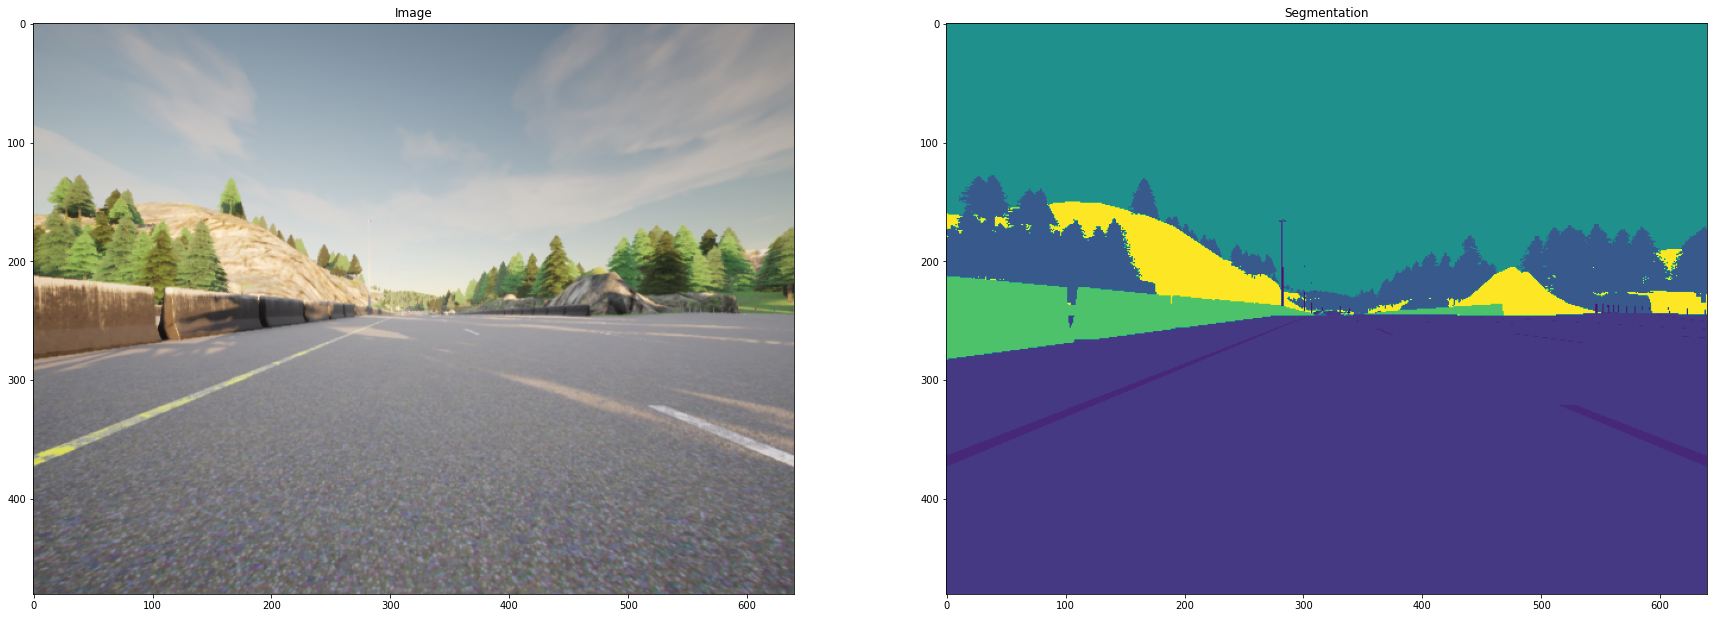

In [51]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(30, 30))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='2-1'></a>
### 2.1 - Split Your Dataset into Unmasked and Masked Images

In [52]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000028.png'>)


In [53]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(4):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/002128.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/002128.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraRGB/008579.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/008579.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraRGB/015232.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/015232.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraRGB/006878.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/006878.png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.2 - Preprocess Your Data



In [54]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

<a name='3'></a>
## 3 - U-Net 



<a name='3-1'></a>
### 3.1 - Model Details


**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total. 

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 




In [55]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
  
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
  
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob, input_shape=inputs.shape)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer =MaxPooling2D(pool_size=(2, 2))(conv)

        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)



In [57]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding="same")(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

<a name='3-4'></a>
### 3.4 - Build the Model


In [59]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    
    inputs = Input(input_size)
    # Contracting Path (encoding)
    cblock1 = conv_block(inputs,  n_filters=32)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters=64)
    cblock3 = conv_block(cblock2[0], n_filters=128)
    cblock4 = conv_block(cblock3[0], n_filters=256,dropout_prob=0.3) # Include a dropout of 0.3 for this layer
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters=512, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],   n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters )

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [61]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Check out the model summary below! 

In [62]:
unet.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 96, 128, 32)  896         input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 96, 128, 32)  9248        conv2d_72[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 48, 64, 32)   0           conv2d_73[0][0]                  
______________________________________________________________________________________

<a name='3-6'></a>
### 3.6 - Loss Function


In [63]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<a name='3-7'></a>
### 3.7 - Dataset Handling


In [64]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(96, 128, 1)


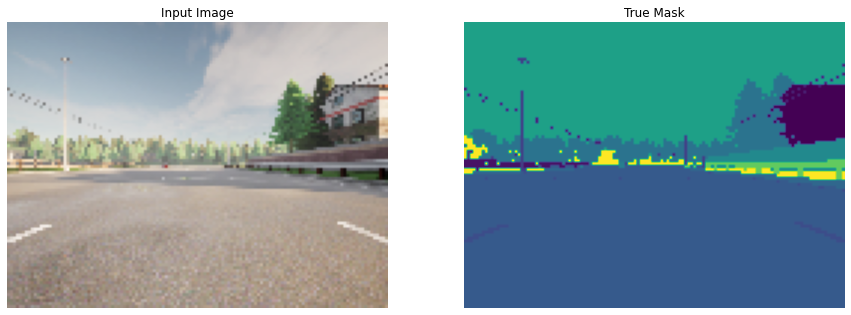

In [66]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
## 4 - Train the Model

In [67]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
34/34 [==============================] - 15s 431ms/step - loss: 1.7811 - accuracy: 0.4759
Epoch 2/40
34/34 [==============================] - 2s 45ms/step - loss: 0.7666 - accuracy: 0.8050
Epoch 3/40
34/34 [==============================] - 1s 40ms/step - loss: 0.5647 - accuracy: 0.8419
Epoch 4/40
34/34 [==============================] - 2s 45ms/step - loss: 0.4618 - accuracy: 0.8671
Epoch 5/40
34/34 [==============================] - 2s 45ms/step - loss: 0.4033 - accuracy: 0.8799
Epoch 6/40
34/34 [==============================] - 1s 39ms/step - loss: 0.3524 - accuracy: 0.8925
Epoch 7/40
34/34 [==============================] - 2s 44ms/step - loss: 0.3146 - accuracy: 0.9047
Epoch 8/40
34/34 [==============================] - 1s 39ms/step - loss: 0.2731 - accuracy: 0.9184
Epoch 9/40
34/34 [==============================] - 2s 45ms/step - loss: 0.2419 - acc

<a name='4-1'></a>
### 4.1 - Create Predicted Masks 


In [68]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy



In [69]:
model_history.history.keys()

dict_keys(['loss', 'accuracy'])

Text(0.5, 0, 'epoch')

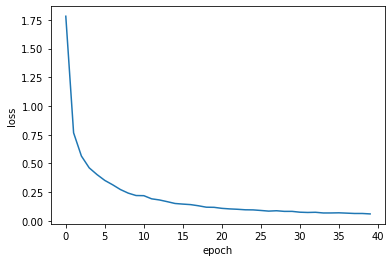

In [70]:
plt.plot(model_history.history["loss"])
plt.ylabel('loss')
plt.xlabel('epoch')

In [71]:
a=model_history.history["accuracy"]
for i in range(EPOCHS):
    print("EPOCH {}  : Model Accuracy {}".format(i+1, a[i]))
    

EPOCH 1  : Model Accuracy 0.47588127851486206
EPOCH 2  : Model Accuracy 0.8050094842910767
EPOCH 3  : Model Accuracy 0.8418648838996887
EPOCH 4  : Model Accuracy 0.8670589923858643
EPOCH 5  : Model Accuracy 0.8799199461936951
EPOCH 6  : Model Accuracy 0.8925248384475708
EPOCH 7  : Model Accuracy 0.9047438502311707
EPOCH 8  : Model Accuracy 0.9183642268180847
EPOCH 9  : Model Accuracy 0.9282724261283875
EPOCH 10  : Model Accuracy 0.934583306312561
EPOCH 11  : Model Accuracy 0.9352887868881226
EPOCH 12  : Model Accuracy 0.9434816837310791
EPOCH 13  : Model Accuracy 0.9458391666412354
EPOCH 14  : Model Accuracy 0.9502736330032349
EPOCH 15  : Model Accuracy 0.9552084803581238
EPOCH 16  : Model Accuracy 0.9567673802375793
EPOCH 17  : Model Accuracy 0.9579139947891235
EPOCH 18  : Model Accuracy 0.9609516263008118
EPOCH 19  : Model Accuracy 0.9646910429000854
EPOCH 20  : Model Accuracy 0.964606523513794
EPOCH 21  : Model Accuracy 0.967531144618988
EPOCH 22  : Model Accuracy 0.9687452912330627

Text(0.5, 0, 'epoch')

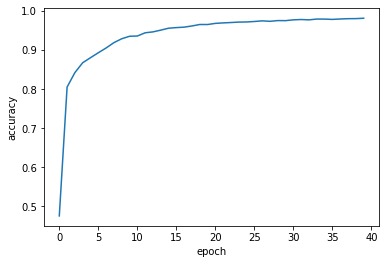

In [72]:
plt.plot(model_history.history["accuracy"])
plt.ylabel('accuracy')
plt.xlabel('epoch')

<a name='4-3'></a>
### 4.3 - Show Predictions 



In [73]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

In [76]:
train = image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
show_predictions(train, 1)

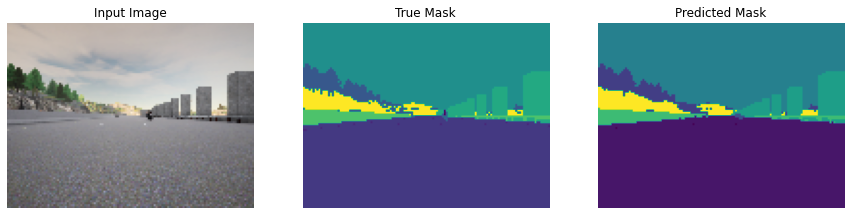

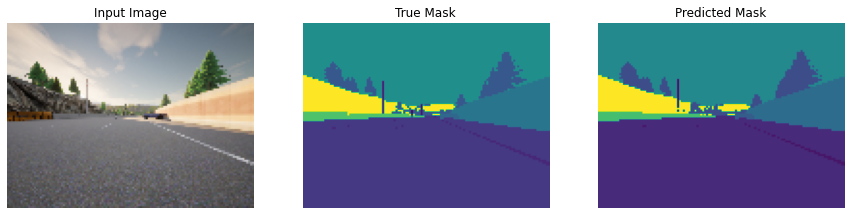

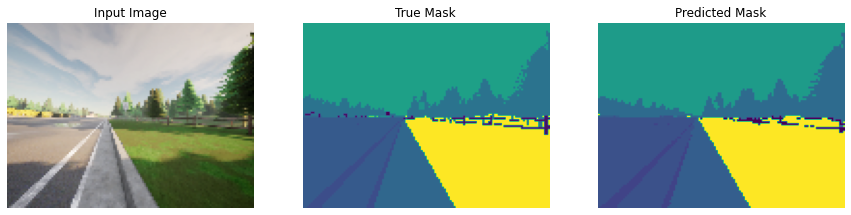

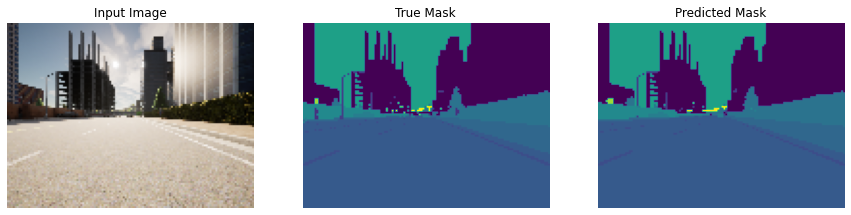

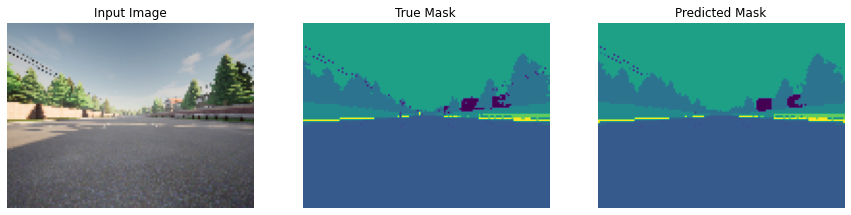

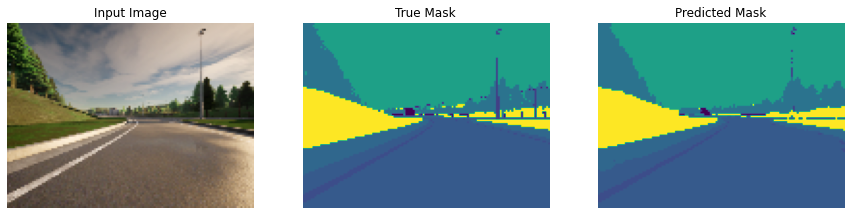

In [74]:
show_predictions(train_dataset, 6)